In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

From table 2 of https://www.cdc.gov/flu/about/burden/2018-2019.html

In [2]:
with open("static-data/cdc-flu-rates-estimate.html", "r") as f:
    flu = pd.read_html(f)[0]
flu = flu.set_index(("Unnamed: 0_level_0", "Age group"))
flu.index.name = "Age group"
uniq_cols = sorted(list({name for name, descriptor in flu.columns}))
assert uniq_cols == ['Hospitalization rate', 'Illness rate', 'Medical visit rate', 'Mortality rate']
show_cols = [(c, "Estimate") for c in uniq_cols]
flu = flu[show_cols]
flu.columns = ["hosp_rate", "illness_rate", "med_visit_rate", "death_rate"]

flu /= 100e3
assert (flu.index == ['0-4 yrs', '5-17 yrs', '18-49 yrs', '50-64 yrs', '65+ yrs']).all()
flu["min_age"] = [0, 5, 18, 50, 65]
flu["max_age"] = [4, 17, 49, 64, 110]
flu = flu.reset_index()
flu["virus"] = "flu"
flu

,Age group,hosp_rate,illness_rate,med_visit_rate,death_rate,min_age,max_age,virus
0,0-4 yrs,0.001279,0.183395,0.122875,0.000013,0,4,flu
1,5-17 yrs,0.000392,0.143001,0.074361,0.000004,5,17,flu
2,18-49 yrs,0.000484,0.086215,0.031900,0.000018,18,49,flu
3,50-64 yrs,0.001551,0.146271,0.062896,0.000090,50,64,flu
4,65+ yrs,0.005329,0.058614,0.032824,0.000487,65,110,flu


From page 16 of https://www.health.state.mn.us/diseases/coronavirus/stats/covidweekly31.pdf

In [3]:
mn = [
    {"age_range": "0-5",   "num_cases": 1158,  "hosp": 51,  "icu": 11,  "deaths": 1},
    {"age_range": "6-19",  "num_cases": 6131,  "hosp": 128, "icu": 30,  "deaths": 0},
    {"age_range": "20-29", "num_cases": 12728, "hosp": 394, "icu": 54,  "deaths": 3},
    {"age_range": "30-39", "num_cases": 9940,  "hosp": 527, "icu": 104, "deaths": 13},
    {"age_range": "40-49", "num_cases": 7762,  "hosp": 605, "icu": 182, "deaths": 21},
    {"age_range": "50-59", "num_cases": 6886,  "hosp": 926, "icu": 311, "deaths": 80},
    {"age_range": "60-69", "num_cases": 4090,  "hosp": 929, "icu": 355, "deaths": 194},
    {"age_range": "70-79", "num_cases": 2192,  "hosp": 748, "icu": 245, "deaths": 302},
    {"age_range": "80-89", "num_cases": 1805,  "hosp": 598, "icu": 164, "deaths": 537},
    {"age_range": "90-99", "num_cases": 939,   "hosp": 196, "icu": 33,  "deaths": 412},
    {"age_range": "100-109", "num_cases": 53, "hosp": 9, "icu": 0, "deaths": 31},
]
mn = pd.DataFrame(mn)
mn["min_age"] = mn.age_range.apply(lambda x: int(x.split("-")[0]))
mn["max_age"] = mn.age_range.apply(lambda x: int(x.split("-")[1]))

In [4]:
import numpy as np
for col in ["num_cases", "hosp", "icu", "deaths"]:
    mn.loc[mn[col] <= 1, col] = np.nan
mn["hosp_rate"] = mn["hosp"] / mn["num_cases"]
mn["icu_rate"] = mn["icu"] / mn["num_cases"]
mn["death_rate"] = mn["deaths"] / mn["num_cases"]
mn["virus"] = "covid"
mn.head(n=5)

,age_range,num_cases,hosp,icu,deaths,min_age,max_age,hosp_rate,icu_rate,death_rate,virus
0,0-5,1158.0,51.0,11.0,NaN,0,5,0.044041,0.009499,NaN,covid
1,6-19,6131.0,128.0,30.0,NaN,6,19,0.020878,0.004893,NaN,covid
2,20-29,12728.0,394.0,54.0,3.0,20,29,0.030955,0.004243,0.000236,covid
3,30-39,9940.0,527.0,104.0,13.0,30,39,0.053018,0.010463,0.001308,covid
4,40-49,7762.0,605.0,182.0,21.0,40,49,0.077944,0.023448,0.002705,covid


From CSV table at https://mn.gov/admin/demography/data-by-topic/population-data/our-projections/

In [5]:
pop = pd.read_csv("static-data/minnesota-population.csv")
pop.columns = pop.iloc[4].tolist()
pop = pop.iloc[5:]
pop = pop[pop.Sex == "Total"]
pop = pop.set_index("Age")
pop = pop["2016**"].astype("int")
pop.sample(n=2)

Age
21    72442
22    74052
Name: 2016**, dtype: int64

In [6]:
def _get_age_pop(row, pop=None):
    if row.min_age < 100:
        ages = list(range(row.min_age, row.max_age + 1))
        age_pop = pop[ages].sum()
    else:
        age_pop = pop["100+"]
    return age_pop
    
mn["population"] = mn.apply(_get_age_pop, pop=pop, axis=1)
mn["illness_rate"] = mn["num_cases"] / mn["population"]
mn.population.sum() / 1e6  # close to 5.3 million, the 2010 census

5.519952

In [7]:
mn.to_csv("data/mn-covid-data.csv", index=False)

In [8]:
cols = ["hosp_rate", "death_rate", "illness_rate", "icu_rate", "min_age", "max_age", "virus", "med_visit_rate", "population"]
# cols = df.columns
df = pd.concat((mn, flu))[cols]
df = df.melt(id_vars=[c for c in cols if "age" not in c], value_name="age").drop(columns="variable")
# df.loc[df.death_rate <= 1e-16, "death_rate"] = np.nan
df.head()

,hosp_rate,death_rate,illness_rate,icu_rate,virus,med_visit_rate,population,age
0,0.044041,NaN,0.002737,0.009499,covid,NaN,423100.0,0
1,0.020878,NaN,0.006096,0.004893,covid,NaN,1005801.0,6
2,0.030955,0.000236,0.017380,0.004243,covid,NaN,732327.0,20
3,0.053018,0.001308,0.013379,0.010463,covid,NaN,742952.0,30
4,0.077944,0.002705,0.011696,0.023448,covid,NaN,663636.0,40


In [9]:
df.head(n=4)

,hosp_rate,death_rate,illness_rate,icu_rate,virus,med_visit_rate,population,age
0,0.044041,NaN,0.002737,0.009499,covid,NaN,423100.0,0
1,0.020878,NaN,0.006096,0.004893,covid,NaN,1005801.0,6
2,0.030955,0.000236,0.017380,0.004243,covid,NaN,732327.0,20
3,0.053018,0.001308,0.013379,0.010463,covid,NaN,742952.0,30


In [10]:
df.to_csv("data/mn+flu.csv", index=False)

In [11]:
colors = {
    "covid": "C0",
    "flu": "C1",
}

In [12]:
df.head()

,hosp_rate,death_rate,illness_rate,icu_rate,virus,med_visit_rate,population,age
0,0.044041,NaN,0.002737,0.009499,covid,NaN,423100.0,0
1,0.020878,NaN,0.006096,0.004893,covid,NaN,1005801.0,6
2,0.030955,0.000236,0.017380,0.004243,covid,NaN,732327.0,20
3,0.053018,0.001308,0.013379,0.010463,covid,NaN,742952.0,30
4,0.077944,0.002705,0.011696,0.023448,covid,NaN,663636.0,40


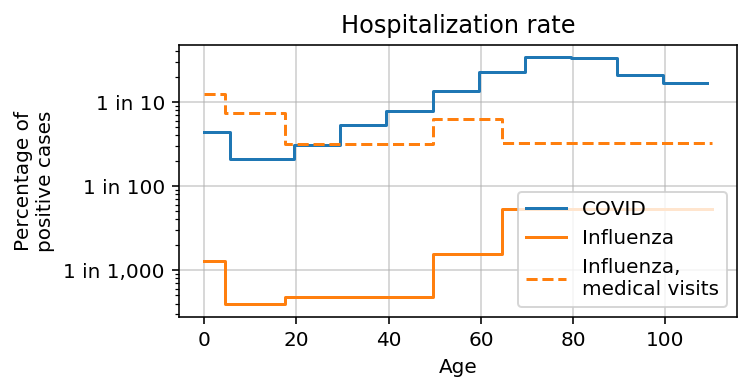

In [30]:
kwargs = dict(
    x="age",
    hue="virus",
    drawstyle="steps-mid",
    data=df,
)
df = df.sort_values(by="age")

kwargs = dict(drawstyle="steps-mid")
w = 2.5
fig, ax = plt.subplots(figsize=(2 * w, 1 * w))
s = df[df.virus == "covid"]
ax.plot(s.age, s.hosp_rate, colors["covid"], label="COVID", **kwargs)

s = df[df.virus == "flu"]
ax.plot(s.age, s.hosp_rate, colors["flu"] + "-", label="Influenza", **kwargs)
ax.plot(s.age, s.med_visit_rate, colors["flu"] + "--", label="Influenza,\nmedical visits", **kwargs)
ax.legend(loc="best")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x * 100)))
ax.set_title("Hospitalization rate")
ax.set_xlabel("Age")
ax.set_ylabel("Percentage of\npositive cases")
ax.grid(alpha=0.6)
ax.set_yscale("log")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "1 in {:,}".format(int(1 / x))))
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
fig.savefig("imgs/mn-hosp-rate.png", dpi=300, bbox_inches="tight")

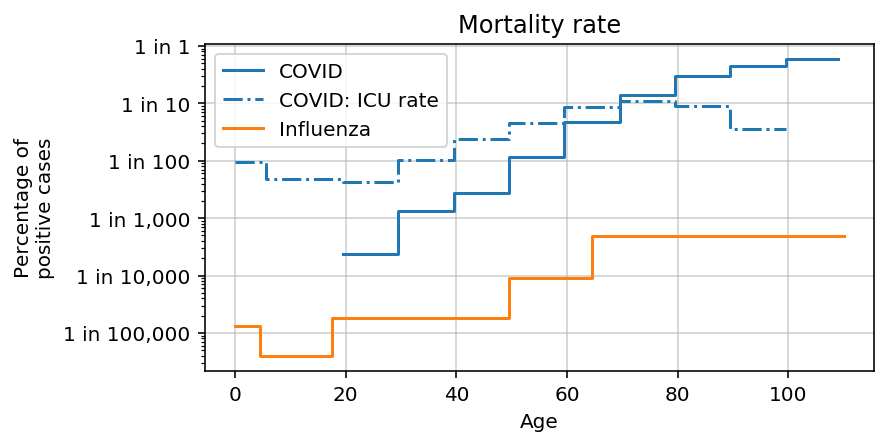

In [31]:
import seaborn as sns

s = df.copy()
kwargs = dict(
    drawstyle="steps-mid",
)

w = 3
fig, ax = plt.subplots(figsize=(2 * w, w))
t = s[s.virus == "covid"]
ax.plot(t.age, t.death_rate, label="COVID", **kwargs)
ax.plot(t.age, t.icu_rate, colors["covid"] + "-.", label="COVID: ICU rate", **kwargs)
t = s[s.virus == "flu"]
ax.plot(t.age, t.death_rate, label="Influenza", **kwargs)

ax.set_yscale("log")
ax.set_title("Mortality rate")
ax.set_xlabel("Age")
ax.set_ylabel("Percentage of\npositive cases")

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "1 in {:,}".format(int(np.round(1 / x)))))
ax.grid(alpha=0.6)
ax.legend(loc="best")
fig.savefig("imgs/mn-death-rate.png", dpi=300, bbox_inches="tight")

0.183395


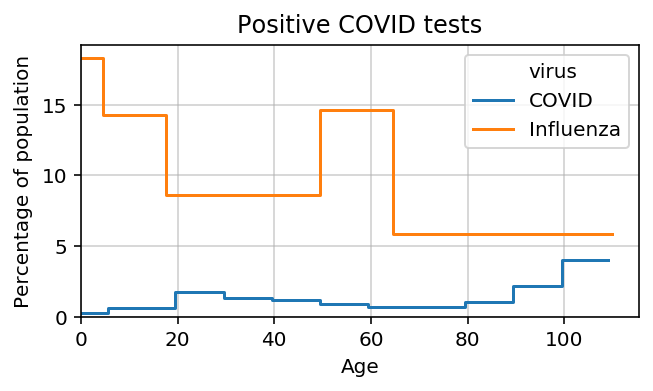

In [32]:

import seaborn as sns

s = df.copy()

# If 90-100 reaches herd immunity
s.loc[s.virus == "covid", "illness_rate"] *= 1#27.3
s["illness_rate"] = np.clip(s["illness_rate"], 0, 1)
print(s["illness_rate"].max())
s.loc[s.virus == "covid", "virus"] = "COVID"
s.loc[s.virus == "flu", "virus"] = "Influenza"

kwargs = dict(
    x="age",
    hue="virus",
    drawstyle="steps-mid",
    data=s,
)

w = 2.5
fig, ax = plt.subplots(figsize=(2 * w, w))
ax = sns.lineplot(y="illness_rate", ax=ax, **kwargs)
# ax.set_yscale("log")
ax.set_title("Positive COVID tests")
ax.set_xlabel("Age")
ax.set_ylabel("Percentage of population")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(100 * x)))
ax.set_ylim(0, None)
ax.set_xlim(0, None)
ax.grid(alpha=0.6)
fig.savefig("imgs/infection-rate.png", dpi=300, bbox_inches="tight")

Confirmed cases by age: Figure 1 of https://www.cdc.gov/mmwr/volumes/69/wr/pdfs/mm6915e3-H.pdf

Child spread: https://www.icpcovid.com/sites/default/files/2020-07/The%20Child%20is%20not%20to%20Blame%20peds.2020-004879.full_.pdf, "COVID-19 Transmission and C hildren: The Child is Not to Blame", Pediatrics. Benjamin Lee, MD and William V. Raszka, Jr., MD.

Page 14 of https://www.cdc.gov/coronavirus/2019-ncov/covid-data/pdf/covidview-07-31-2020.pdf has an interesting graph with percentage of deaths.

(unused) graph of hospitalizations by age for entire US: https://www.statista.com/statistics/1122354/covid-19-us-hospital-rate-by-age/

In [17]:
# df = df.fillna(0)
# df.head()

p_pos = df["illness_rate"]
df["p_death"] = p_pos * df["death_rate"]
df["p_hosp"] = p_pos * df["hosp_rate"]
df["p_icu"] = p_pos * df["icu_rate"]

In [18]:
s = df.copy()
s = s.sort_values(by="age")

# cols = ["Death", "ICU", "Hospitalization", "age", "virus"]
cols = ["p_death", "p_hosp", "age", "virus"]
# s = s[cols].melt(id_vars=["age", "virus"], var_name="Item", value_name="Chance")
s.head()

,hosp_rate,death_rate,illness_rate,icu_rate,virus,med_visit_rate,population,age,p_death,p_hosp,p_icu
0,0.044041,NaN,0.002737,0.009499,covid,NaN,423100.0,0,NaN,0.000121,0.000026
11,0.001279,0.000013,0.183395,NaN,flu,0.122875,NaN,0,2.384135e-06,0.000235,NaN
27,0.001279,0.000013,0.183395,NaN,flu,0.122875,NaN,4,2.384135e-06,0.000235,NaN
16,0.044041,NaN,0.002737,0.009499,covid,NaN,423100.0,5,NaN,0.000121,0.000026
12,0.000392,0.000004,0.143001,NaN,flu,0.074361,NaN,5,5.720040e-07,0.000056,NaN


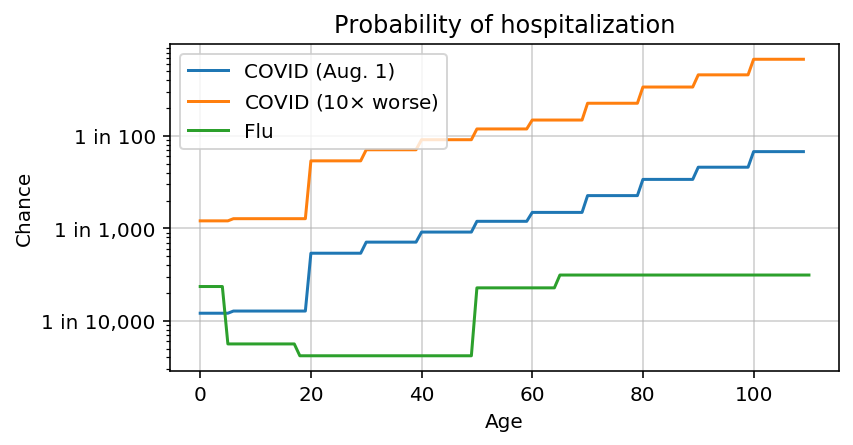

In [19]:
w = 3
fig, ax = plt.subplots(figsize=(2 * w, w))

y = "p_hosp"
factor = 10

t = s[(s.virus == "covid")]
ax.plot(t["age"], 1 * t[y], label="COVID (Aug. 1)")
ax.plot(t["age"], factor * t[y], label=f"COVID ({factor}$\\times$ worse)")
t = s[(s.virus == "flu")]
ax.plot(t["age"], 1 * t[y], label="Flu")

ax.legend(loc="best")
ax.set_yscale("log", basey=10)
ax.grid(alpha=0.6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "1 in {:,}".format(int(np.round(1 / x)))))
ax.set_ylabel("Chance")
ax.set_xlabel("Age")
ax.set_title("Probability of hospitalization")
# fig.savefig("imgs/hosp-risk.png", dpi=300, bbox_inches="tight")